In [197]:
from glob import glob
import librosa
from librosa import display
import soundfile as sf
import numpy as np
import pandas as pd
import sys
import time
import datetime
from tqdm import tqdm
import random
import os
import gc
import cv2

from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, AdamW, lr_scheduler
from torch.distributions import Uniform
from torch.utils.data import DataLoader, Dataset

from torchlibrosa.stft import Spectrogram, LogmelFilterBank
from torchlibrosa.augmentation import SpecAugmentation


from efficientnet_pytorch import EfficientNet
from torchvision.models import resnet34, resnet50

import sys
sys.path.append('..')
from libs import transform as tr
from libs import spectrogram as spec
from libs import criterion as cr

import warnings
warnings.filterwarnings("ignore")


from pylab import rcParams
rcParams['figure.figsize'] = 10,20

import matplotlib.pyplot as plt

In [198]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = False  # type: ignore
set_seed(53)

In [199]:
create_path = lambda x: f"/home/yuigahama/kaggle/rfcx/data/train/{x}.flac"

In [200]:
train_tp = pd.read_csv('../../data/train_tp.csv')
train_fp = pd.read_csv('../../data/train_fp.csv')
submission = pd.read_csv('../../data/sample_submission.csv')

pred_target = list(submission.columns)[1:]

SR = 48000
train_fp['recording_id'].unique()

array(['00204008d', '003b04435', '005f1f9a5', ..., 'ffebe7313',
       'fff163132', 'fffb79246'], dtype=object)

In [201]:
ids = []
for i in range(len(train_tp)):
    samp = train_tp.iloc[i]['recording_id']
    if len(train_fp.query(f'recording_id == "{samp}"')) > 0:
        ids.append(samp)

In [231]:
train_tp.query(f'recording_id == "{recording_id}"')['species_id'].iloc[0]

7

In [203]:
samp = train_tp.query(f'recording_id == "{recording_id}"')
t_min = samp['t_min']
t_max = samp['t_max']
f_min = samp['f_min']
f_max = samp['f_max']
record_fp = train_fp.query(f'recording_id == "{recording_id}"')
recording_id

'04e70a8e3'

In [204]:
bboxs = pd.concat([record_fp, samp], axis=0)
bboxs['t_min'] = bboxs['t_min'].apply(lambda x: int(round(x)))
bboxs['t_max'] = bboxs['t_max'].apply(lambda x: int(round(x)))
bboxs['f_min'] = bboxs['f_min'].apply(lambda x: int(round(x)))
bboxs['f_max'] = bboxs['f_max'].apply(lambda x: int(round(x)))

bboxs

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
147,04e70a8e3,6,1,12,562,14,4406
148,04e70a8e3,13,1,44,94,48,1406
149,04e70a8e3,1,1,52,3844,53,5625
150,04e70a8e3,13,1,40,94,44,1406
25,04e70a8e3,7,1,24,4688,27,11438


In [205]:
y, orig_sr = sf.read(create_path(recording_id))

In [215]:
melspec = librosa.feature.melspectrogram(
    y,
    sr=SR,
    fmin=0,
    fmax=15000,
    n_mels=128
)
melspecdb = librosa.power_to_db(melspec)
melspecdb.min()

-58.72687974103457

In [225]:
melspec.shape

(128, 5626)

In [216]:
melspec.min()
"""display.specshow(melspec, sr=SR, x_axis="time", y_axis="mel")
plt.colorbar();"""

'display.specshow(melspec, sr=SR, x_axis="time", y_axis="mel")\nplt.colorbar();'

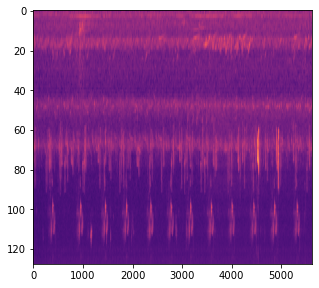

In [181]:
plt.figure(figsize=(5,30))
plt.imshow(melspec, cmap='magma', aspect=40)

In [182]:
time_rate = 5626 / 60

freq_rate = 128 / 15000

In [186]:
melspec.min()

-49.389434337695604

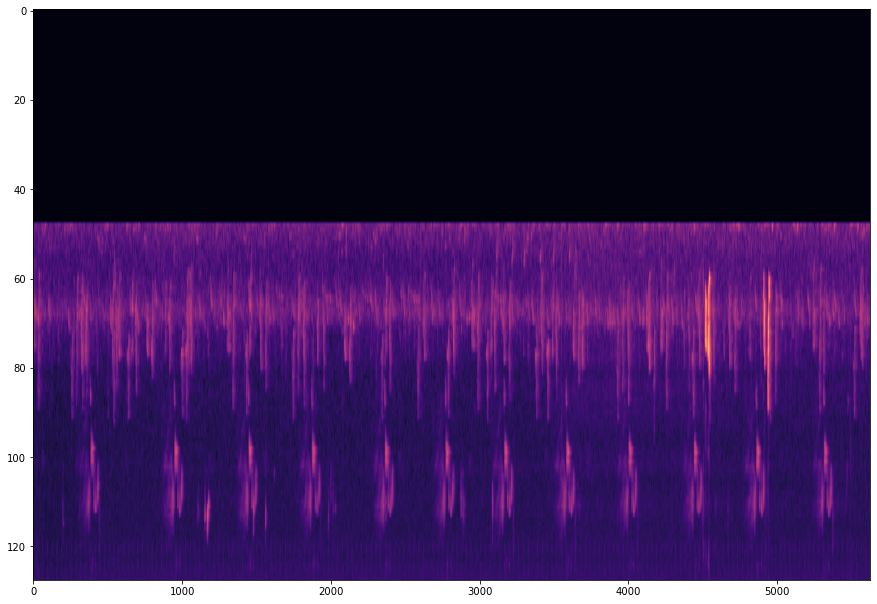

In [191]:
melspec = librosa.feature.melspectrogram(
    y,
    sr=SR,
    fmin=0,
    fmax=15000,
    n_mels=128
)
melspec = librosa.power_to_db(melspec)

for i in range(len(record_fp)):
    sample = record_fp.iloc[i]
    f_min = int(sample['f_min'] * freq_rate)
    f_max = int(sample['f_max'] * freq_rate)
    
    melspec[f_min:f_max, :] = -49
    
    #cv2.rectangle(melspec,(t_min,f_min),(t_max,f_max),(0,0,255),3)
plt.figure(figsize=(15,30))
plt.imshow(melspec, cmap='magma', aspect=30)

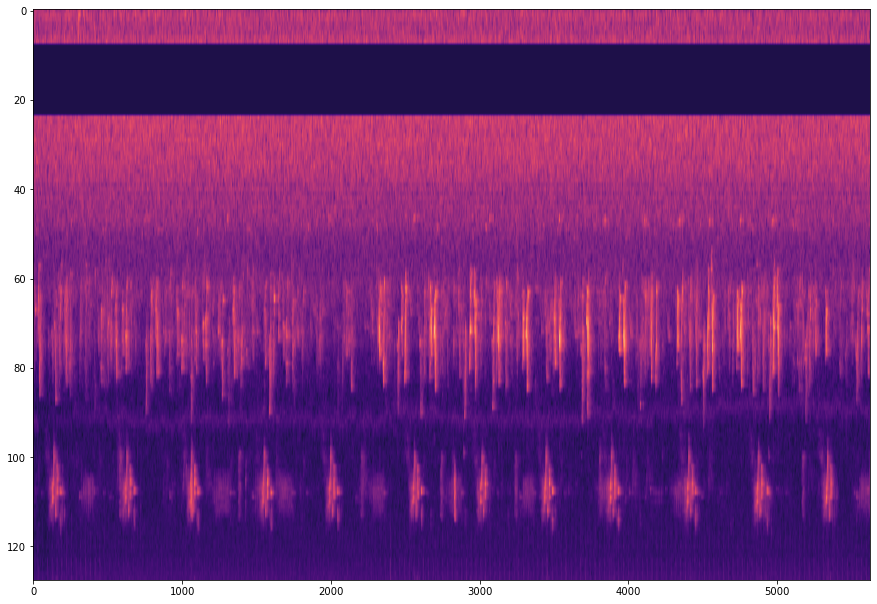

In [196]:
tmp_id = train_tp.query('species_id == 7').iloc[0]['recording_id']

y, orig_sr = sf.read(create_path(tmp_id))

melspec = librosa.feature.melspectrogram(
    y,
    sr=SR,
    fmin=0,
    fmax=15000,
    n_mels=128
)
melspec = librosa.power_to_db(melspec)

for i in range(len(train_fp.query(f'recording_id == "{tmp_id}"'))):
    sample = train_fp.query(f'recording_id == "{tmp_id}"').iloc[i]
    f_min = int(sample['f_min'] * freq_rate)
    f_max = int(sample['f_max'] * freq_rate)
    
    melspec[f_min:f_max, :] = -40

plt.figure(figsize=(15,30))
plt.imshow(melspec, cmap='magma', aspect=30)

In [194]:
train_fp.query(f'recording_id == "{tmp_id}"')

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
52,0209f7ab2,3,1,8.0213,1031.25,8.7627,2812.5
